In [1]:
from PIL import Image
from torchvision import transforms 
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
import torch

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import h5py
import numpy as np
import torch
import torch.nn as nn
from math import sqrt
import matplotlib.pyplot as plt

from dataset import CustomDataset

In [2]:
#dic with energies in eV of elements
dic={ 'Ca':3692,'Mn':5900,'Fe':6405,'Cu':8046,'Au':9713,'Hg':9989,'Pb':10551,'Sr':14165}
num_elements=len(dic)
#load h5 cubes panagia, jesus and hand
f = h5py.File('C:/Users/ioann/Documents/GitHub/Hyperspectral-Image-Analysis/data/panagia1_mm.h5', 'r')
dset=f['dataset']
dEset=f['energies']
spectra_p=np.array(dset)
energies=np.array(dEset)
f.close()

f = h5py.File('C:/Users/ioann/Documents/GitHub/Hyperspectral-Image-Analysis/data/christ.h5', 'r')
dset=f['dataset']
spectra_c=np.array(dset)
f.close()

f = h5py.File('C:/Users/ioann/Documents/GitHub/Hyperspectral-Image-Analysis/data/hand.h5', 'r')
dset=f['dataset']
spectra_h=np.array(dset)
f.close()

#set the number of channels to cut
channels=100
#dimensions of images
rows_p=41
cols_p=65
rows_c=31
cols_c=46
rows_h=41
cols_h=21

#cut first #channels
spectra_p = spectra_p.astype(np.float32)
spectra_c = spectra_c.astype(np.float32)
spectra_h = spectra_h.astype(np.float32)
spectra_p=np.delete(spectra_p,np.s_[:channels],1)
spectra_c=np.delete(spectra_c,np.s_[:channels],1)
spectra_h=np.delete(spectra_h,np.s_[:channels],1)

energies=np.delete(energies,np.s_[:channels])

#Full width at half maximum     
def fwhm(ev):
    return sqrt(2.47*ev+4400)

X_p=torch.tensor(spectra_p)
X_c=torch.tensor(spectra_c)
X_h=torch.tensor(spectra_h)

#Calculate min and max channel of each elements in order to determine the range of interest
key_list=list(dic.keys())
min_ch=[]
max_ch=[]
min_roi_all=[]
max_roi_all=[]
for element in dic:
    min_roi=(dic[element]-fwhm(dic[element])/2)
    min_roi_all.append(min_roi)
    max_roi=(dic[element]+fwhm(dic[element])/2)
    max_roi_all.append(max_roi)
    min_ch.append(int((min_roi+960)/20)-channels)
    max_ch.append(int((max_roi+960)/20)-channels)

#Create target vectors according to ROI
y_p=np.zeros([len(spectra_p),num_elements])
for i in range(len(spectra_p)):
    for j in range(len(key_list)):
        y_p[i][j]=np.sum(np.sum(spectra_p[i,min_ch[j]:max_ch[j]]))
y_c=np.zeros([len(spectra_c),num_elements])
for i in range(len(spectra_c)):
    for j in range(len(key_list)):
        y_c[i][j]=np.sum(np.sum(spectra_c[i,min_ch[j]:max_ch[j]]))
y_h=np.zeros([len(spectra_h),num_elements])
for i in range(len(spectra_h)):
    for j in range(len(key_list)):
        y_h[i][j]=np.sum(np.sum(spectra_h[i,min_ch[j]:max_ch[j]]))
#convert target vectors to tensors
y_p, y_c, y_h = torch.tensor(y_p), torch.tensor(y_c), torch.tensor(y_h)


In [3]:
torch.cat(
    (torch.zeros([50,50]),),
    dim=0
).shape

torch.Size([50, 50])

In [4]:
imagesToTrain = [
    torch.cat((X_h, y_h), dim=1),
    torch.cat((X_p, y_p), dim=1),
]

imagesToTest = [
    torch.cat((X_c, y_c), dim=1),
]

In [5]:
# Hyper-parameters 
input_size = len(spectra_p[0])
hidden_size = 100
output_size = len(key_list)
num_epochs = 500
batch_size = 32
learning_rate = 0.0002

In [6]:
trainSet = CustomDataset(imagesToTrain, numChannels=1948, numElements=8)

trainLoader = DataLoader(
    dataset=trainSet, 
    batch_size=batch_size, 
    shuffle=True
)

testSet = CustomDataset(imagesToTest, numChannels=1948, numElements=8)

testLoader = DataLoader(
    dataset=testSet, 
    batch_size=batch_size, 
    shuffle=False
)

In [7]:
from dataset import CustomDataset
from model import ConvModel
from torch.utils.data import DataLoader

model = ConvModel(num_features=1948, in_channels=1, num_targets=8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [8]:
for epoch in range(num_epochs):

    ### TRAINING ### 
    epoch_loss = 0

    for x_in, y_in in trainLoader:
        optimizer.zero_grad()

        x_in = torch.reshape(x_in, (x_in.shape[0], 1, x_in.shape[1]))    
        y_in = torch.reshape(y_in, (y_in.shape[0], 1, y_in.shape[1]))    

        y_out = model(x_in)

        loss = criterion(y_in, y_out)

        epoch_loss += loss.item() // batch_size

        loss.backward()
        optimizer.step()

    ### TESTING ### 
    test_loss = 0
    for x_in, y_in in testLoader:
        
        x_in = torch.reshape(x_in, (x_in.shape[0], 1, x_in.shape[1]))    
        y_in = torch.reshape(y_in, (y_in.shape[0], 1, y_in.shape[1]))    

        with torch.no_grad():
            y_out = model(x_in)
            loss = criterion(y_in, y_out)
            test_loss += loss.item() // batch_size

    print(epoch, epoch_loss, test_loss)

0 189089.0 2159302.0
1 171877.0 2002369.0
2 142226.0 1697464.0
3 124373.0 1427799.0
4 106202.0 1086415.0
5 77007.0 680820.0
6 48102.0 396824.0
7 27482.0 228829.0
8 13784.0 121550.0
9 6685.0 67365.0
10 3743.0 44202.0
11 2708.0 34794.0
12 2311.0 30119.0
13 2078.0 27482.0
14 1900.0 25726.0
15 1749.0 24321.0
16 1591.0 23134.0
17 1471.0 22237.0
18 1361.0 20628.0
19 1278.0 20586.0
20 1201.0 19497.0
21 1141.0 18632.0
22 1085.0 18111.0
23 1111.0 17689.0
24 978.0 17374.0
25 937.0 16390.0
26 894.0 16169.0
27 851.0 15973.0
28 804.0 15376.0
29 770.0 14910.0
30 724.0 14269.0
31 682.0 13411.0
32 643.0 13516.0
33 592.0 12735.0
34 548.0 12022.0
35 511.0 12126.0
36 472.0 11750.0
37 428.0 11113.0
38 390.0 10828.0
39 355.0 10646.0
40 328.0 10216.0
41 295.0 9920.0
42 266.0 9376.0
43 239.0 9191.0
44 228.0 9321.0
45 213.0 8681.0
46 188.0 8989.0
47 178.0 8379.0
48 171.0 8949.0
49 161.0 8581.0
50 153.0 8875.0
51 152.0 8248.0
52 147.0 8158.0
53 140.0 7460.0
54 143.0 7567.0
55 140.0 8029.0
56 137.0 7590.0
57 13

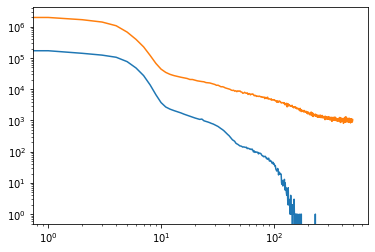

In [16]:
import pandas as pd 

df = pd.read_csv('./out.csv', header=None)  

plt.plot(df[1])
plt.plot(df[2])
plt.yscale("log")
plt.xscale("log")

In [36]:
y_out=model(X_c.reshape(X_c.shape[0],1,X_c.shape[1]))
y_out=y_out.detach().numpy()
y_out = y_out.reshape(rows_c,cols_c,8)

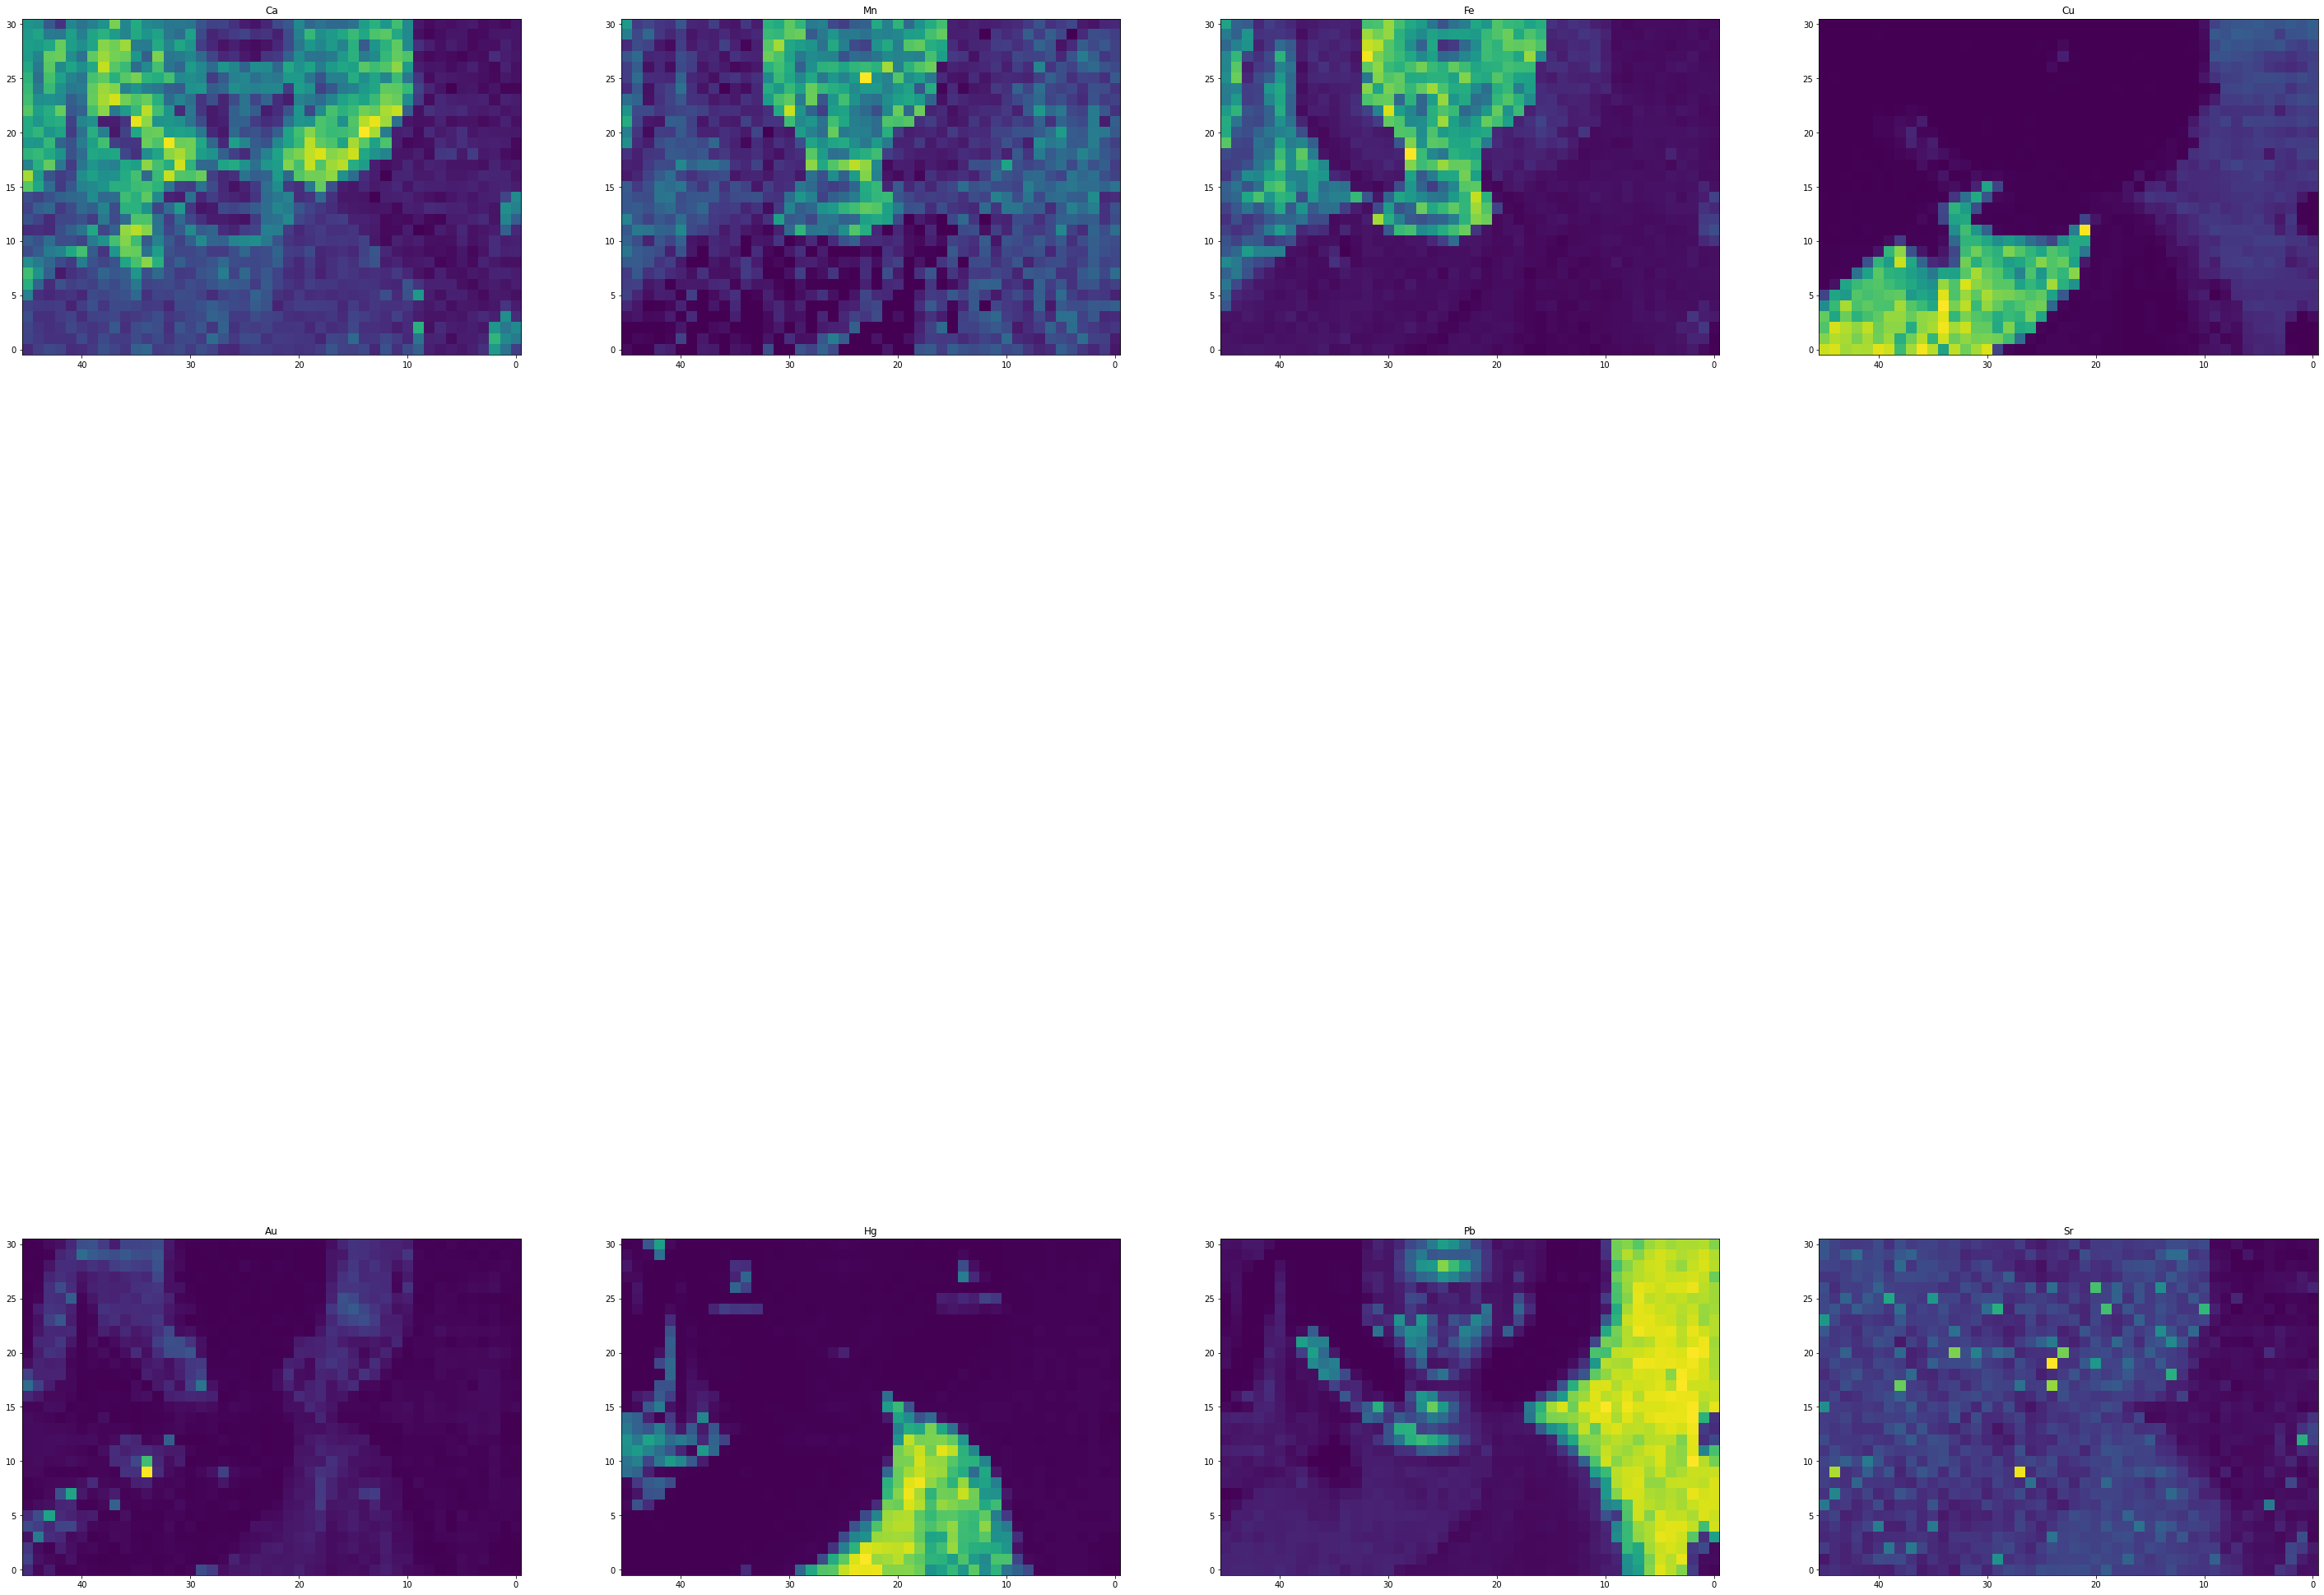

In [37]:
fig, ax = plt.subplots(nrows=2,ncols=4)
fig.set_figheight(50)
fig.set_figwidth(50)
k=0
for i in range(2):
    for j in range(4):
        ax[i][j].imshow(y_out[:,:,k])
        ax[i][j].invert_yaxis()
        ax[i][j].invert_xaxis()
        ax[i][j].title.set_text(key_list[k])
        k+=1